<a href="https://colab.research.google.com/github/Vasavipilli/FMML_ASSIGNMENTS_AND_LABS/blob/main/FMML_Module_9_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 9: Convolutional Neural Networks
## **Lab 4**
### Module coordinator: Kushagra Agarwal

<img src="https://miro.medium.com/max/1200/1*QoqNAg2t6lF8Q6WWA6AbOg.png" width=650px/>

## Using learnt representations
In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest.


We'll train a model to classify ants and bees. We have about 120 training images each for ants and bees. There are 75 validation images for each class. Usually, this is a very small dataset to generalize upon, if trained from scratch. Since we are using transfer learning, we should be able to generalize reasonably well.

This dataset is a very small subset of imagenet.




In [1]:
# Import packages
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time
import os

In [2]:
# Device configuration (whether to run on GPU or CPU)
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Download and extract dataset
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip -q hymenoptera_data.zip

--2024-05-14 05:51:49--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.77, 18.160.200.71, 18.160.200.112, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  85.5MB/s    in 0.5s    

2024-05-14 05:51:49 (85.5 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
val_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

data_dir = './hymenoptera_data'
train_dataset = ImageFolder(os.path.join(data_dir, 'train'), train_transform)
val_dataset = ImageFolder(os.path.join(data_dir, 'val'), val_transform)
train_dataloader = DataLoader(train_dataset, batch_size=4,shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4,shuffle=True, num_workers=2)
class_names = train_dataset.classes


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


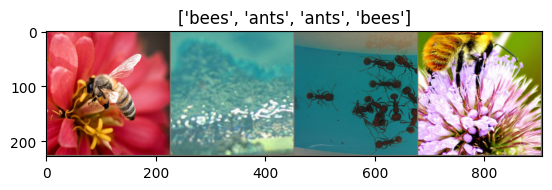

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs=25):

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for i, (inputs, labels) in enumerate(train_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            # track history if only in train
            with torch.set_grad_enabled(True):
              outputs = model(inputs)
              _, preds = torch.max(outputs, 1)
              loss = criterion(outputs, labels)

              # backward + optimize only if in training phase
              loss.backward()
              optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        epoch_acc = running_corrects.double() / len(train_dataloader.dataset)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        print()

In [7]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(val_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
from torchvision import models

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

loss_func = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 33.3MB/s]


In [9]:
num_epochs = 5
train_model(model_ft, train_dataloader, loss_func, optimizer, num_epochs)

Epoch 0/4
----------
Loss: 0.6594 Acc: 0.6721

Epoch 1/4
----------
Loss: 0.5680 Acc: 0.7705

Epoch 2/4
----------
Loss: 0.6138 Acc: 0.7746

Epoch 3/4
----------
Loss: 0.6489 Acc: 0.7746

Epoch 4/4
----------
Loss: 0.4262 Acc: 0.8156



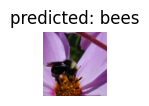

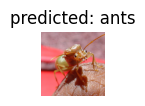

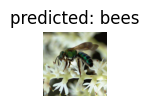

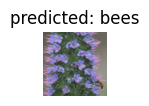

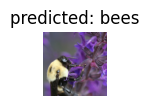

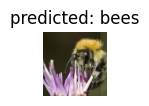

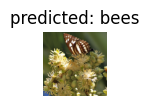

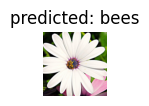

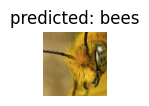

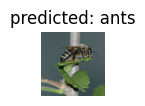

In [10]:
visualize_model(model_ft)

## Example of How Pretrained models are used for Target Tasks

<img src="https://www.researchgate.net/publication/340225334/figure/fig2/AS:960014822944773@1605896778155/Mechanism-of-transfer-learning-using-pre-trained-models.png" width=950px/>

## Questions:
1) What is the significance of using data augmentations like resize, crop etc on training data?

2) What performance do you get if you don't use pretrained resnet model (Hint: Change pretrained=False and train the model)

3) If the resnet model was pre-trained on dataset significantly different than the ants vs bees data, would you still get good performance by using this pretrained model?


3.Using a pre-trained ResNet model on a dataset significantly different from the task at hand, such as the ants vs. bees dataset, can still provide benefits, but the performance may not be as good as when using a model pre-trained on a more similar dataset. Here's why:

Transfer Learning: Pre-trained models capture general features from the dataset they were trained on. Even if the dataset is different, lower-level features like edges, textures, and basic shapes can still be relevant across different datasets. By leveraging transfer learning, you can use these pre-trained features as a starting point and fine-tune the model on the target dataset. While the higher-level features may need adaptation, the lower-level features can still provide valuable information.

Limited Relevance: The relevance of pre-trained features depends on how similar the source dataset is to the target dataset. If the source dataset is significantly different (e.g., pre-trained on ImageNet, a diverse dataset containing a wide range of object categories), the pre-trained features may not directly translate to the target task. However, they can still provide a useful initialization for training on the target dataset.

Domain Shift: If there is a significant domain shift between the source and target datasets (e.g., differences in image quality, object appearances, backgrounds), the performance of the pre-trained model may be limited. In such cases, fine-tuning the pre-trained model on the target dataset becomes crucial to adapt the features to the new domain.

Task Similarity: The performance of the pre-trained model may also depend on the similarity of the tasks. If the tasks are related (e.g., both involve image classification), the pre-trained features may transfer more effectively. However, if the tasks are very dissimilar (e.g., pre-trained on image classification but used for object detection), the transferability of features may be reduced.

In summary, while using a pre-trained ResNet model on a significantly different dataset can still provide benefits through transfer learning, the performance may vary depending on factors such as the relevance of pre-trained features, domain shift, and task similarity. Fine-tuning the pre-trained model on the target dataset is often necessary to adapt the features and achieve optimal performance.







2.Training a deep learning model from scratch without using a pre-trained ResNet model can significantly affect its performance, especially if the dataset is not large enough to train a complex model effectively. When you train a neural network from scratch, the model starts with random weights, and the optimization process involves updating these weights based on the gradients computed during backpropagation.

Here are some potential outcomes when training a ResNet model from scratch without using pre-trained weights:

Lower Performance: Without pre-trained weights, the model may struggle to converge to an optimal solution, resulting in lower performance compared to using pre-trained weights. This is particularly true if the dataset is small or lacks diversity.

Increased Training Time: Training a deep neural network from scratch requires more time and computational resources compared to fine-tuning a pre-trained model. The model needs to learn features from scratch, which typically requires training for more epochs.

Higher Risk of Overfitting: Training from scratch increases the risk of overfitting, especially if the dataset is small. The model may memorize the training data rather than learn generalizable features, leading to poor performance on unseen data.

Limited Generalization: Models trained from scratch may have limited generalization ability, especially if the dataset is not representative of the target domain. Pre-trained models, on the other hand, have learned generic features from large-scale datasets and can better transfer knowledge to new tasks or domains.

Potential for Local Optima: Training from scratch increases the likelihood of getting stuck in local optima, especially with deep architectures. Pre-trained models often provide a better starting point in the parameter space, facilitating faster convergence to a good solution.

Overall, while it's possible to train a ResNet model from scratch, it may not yield optimal performance, especially in scenarios with limited data or computational resources. Fine-tuning a pre-trained model is often a more effective approach, as it leverages features learned from large-scale datasets and requires less training time and data.







1.Data augmentation, including techniques like resizing, cropping, rotating, flipping, and adding noise to training data, is crucial in machine learning, especially for tasks like image classification, object detection, and segmentation. Here's why:

Increased Variability: By applying different augmentations to the training data, you effectively increase the variability of the dataset. This helps the model to learn a more robust representation of the underlying patterns in the data. For example, an image classifier trained with augmented data will be more resilient to variations in the input images, such as changes in scale, orientation, or lighting conditions.

Regularization: Data augmentation acts as a form of regularization by adding noise to the training data. This can help prevent overfitting, where the model learns to memorize the training examples rather than generalize well to unseen data. Augmentation introduces variations that force the model to learn more generalizable features.

Avoiding Overfitting: Augmentation techniques make the model less sensitive to specific characteristics of the training data, reducing the risk of overfitting. Instead of relying heavily on the exact appearance of the training samples, the model learns to focus on the underlying features that are invariant to the applied augmentations.

Addressing Data Imbalance: In datasets where certain classes are underrepresented, data augmentation can be used to artificially increase the number of samples for those classes. This helps to balance the distribution of classes in the training data, leading to better performance, especially for classifiers.

Improved Generalization: Models trained with augmented data tend to generalize better to unseen examples. Since they have been exposed to a wider range of variations during training, they are better equipped to handle the variability present in real-world data.

Reducing Annotation Effort: Augmentation can sometimes reduce the need for manual data annotation. For example, by applying random rotations and flips to images, you effectively create new training samples without requiring additional annotations.

In summary, data augmentation is a powerful technique for improving the performance and generalization ability of machine learning models, particularly in scenarios where training data is limited or prone to overfitting. It helps models learn more robust and invariant representations of the underlying patterns in the data.